In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Variational Autoencoder

![vae](https://github.com/bayesgroup/deepbayes-2018/blob/master/day2_vae/vae.png?raw=true)

## Task 1: Fill in the code to perform the reparametrization trick:

$$ z = \mu + \epsilon \cdot \sigma. $$

In [25]:
features = 16
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()

        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)

        # decoder
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = #TODO: Fill in your code
        return sample

    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

In [26]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [27]:
# leanring parameters
epochs = 10
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [29]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

In [30]:
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

In [31]:
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

### VAE model:

\begin{align}
& p(x, z) =  p(z) p(x \mid z) \\
& p(z) = \mathcal N(z \mid 0, I) \\
& p(x \mid z) = \prod_{i = 1}^D p_i(z)^{x_i} (1 - p_i(z))^{1 - x_i}.
\end{align}

## Task 2: Complete the loss function

$$ \frac{1}{N} \sum_{n=1}^N \log p(x_n \mid z_n) -\text{KL}(q(z_n |x_n) \| p(z_n)).$$

Hint: BCE loss in pytorch https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

In [32]:
def final_loss(reconstruction, data, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    #TODO: your code here
    return

In [33]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        loss = final_loss(reconstruction, data, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [34]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [35]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10


938it [00:27, 34.11it/s]                         
157it [00:02, 54.21it/s]                         


Train Loss: 217.7397
Val Loss: 167.1649
Epoch 2 of 10


938it [00:28, 32.94it/s]
157it [00:02, 67.24it/s]                         


Train Loss: 156.0092
Val Loss: 145.5962
Epoch 3 of 10


938it [00:28, 32.96it/s]
157it [00:02, 72.22it/s]                         


Train Loss: 140.8945
Val Loss: 135.1423
Epoch 4 of 10


938it [00:28, 33.01it/s]                         
157it [00:02, 64.16it/s]                         


Train Loss: 132.8023
Val Loss: 128.7263
Epoch 5 of 10


938it [00:27, 33.90it/s]                         
157it [00:02, 71.01it/s]                         


Train Loss: 127.5353
Val Loss: 124.5190
Epoch 6 of 10


938it [00:27, 33.52it/s]                         
157it [00:02, 60.53it/s]                         


Train Loss: 123.7311
Val Loss: 121.1049
Epoch 7 of 10


938it [00:28, 32.97it/s]
157it [00:02, 70.72it/s]                         


Train Loss: 120.8919
Val Loss: 118.6691
Epoch 8 of 10


938it [00:27, 33.92it/s]                         
157it [00:02, 70.76it/s]


Train Loss: 118.6596
Val Loss: 116.7380
Epoch 9 of 10


938it [00:27, 33.83it/s]                         
157it [00:03, 50.16it/s]                         


Train Loss: 116.9125
Val Loss: 115.1874
Epoch 10 of 10


938it [00:28, 33.44it/s]                         
157it [00:02, 66.35it/s]                         

Train Loss: 115.5235
Val Loss: 113.9914


## Task 3: Use the VAE decoder to reconstruct images from random gaussian noises.

Hint: Go back to the definition of the model and inspect the decoder.

In [38]:
def sample_vae(model, n_samples=50):
    with torch.no_grad():
        z = torch.randn(n_samples, features).to(device)
        #TODO: your code here
        samples = #TODO: your code here
        samples = samples.view(n_samples, 28, 28).cpu().numpy()
    return samples

def plot_samples(samples, h=5, w=10):
    fig, axes = plt.subplots(nrows=h,
                             ncols=w,
                             figsize=(int(1.4 * w), int(1.4 * h)),
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')

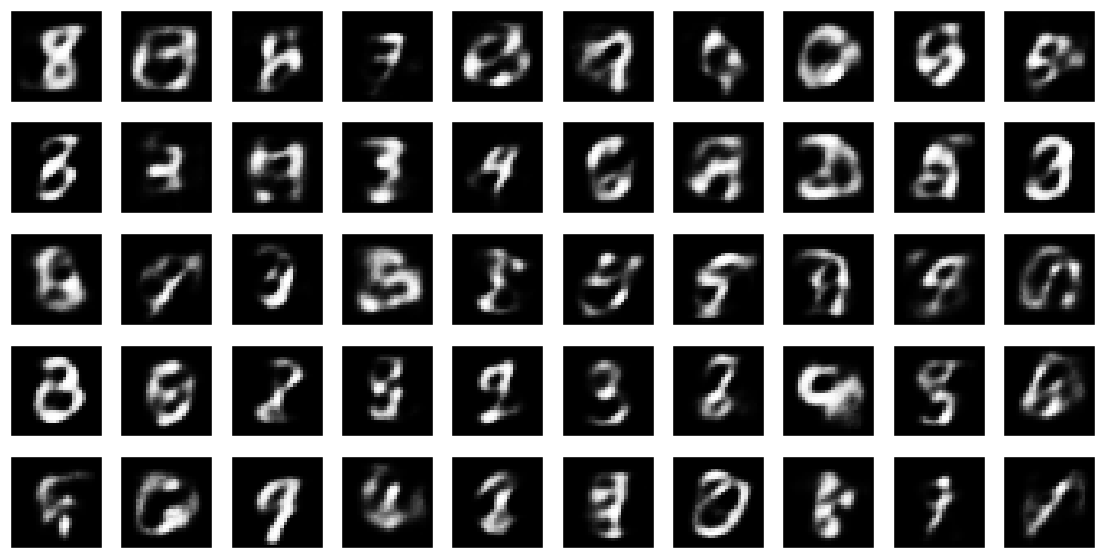

In [39]:
plot_samples(sample_vae(model=model))